In [1]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="sentiment-analysis",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 5e-5,
    "epochs": 1,
    "val_period": 1000,
    "train_batch_size":16,
    "eval_batch_size":32,
    "max_steps":20000
    }
    
)



wandb: Currently logged in as: mguddamsetty. Use `wandb login --relogin` to force relogin


In [2]:
from pathlib import Path
config = wandb.config
checkpoint_path=Path(wandb.run.dir)/"checkpoints"
checkpoint_path.mkdir()
config["checkpoint_path"]=checkpoint_path

In [3]:
import torch
from transformers import AutoTokenizer, RobertaForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
model.to("cuda:0")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt").to("cuda:0")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'optimism'

In [4]:
import torch
import pandas as pd

from torch.utils.data import DataLoader, Dataset
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe.reset_index()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index:index+1]
# Create a dataset
train_df = pd.read_csv("amazon/train.csv")
val_df = pd.read_csv("amazon/val.csv")
test_df = pd.read_csv("amazon/test.csv")

# Create a dataloader
train_loader = DataLoader(PandasDataset(train_df), batch_size=config.train_batch_size,collate_fn=pd.concat, shuffle = True)
val_loader = DataLoader(PandasDataset(val_df), batch_size=config.eval_batch_size,collate_fn=pd.concat, shuffle = False)
test_loader = DataLoader(PandasDataset(test_df), batch_size=config.eval_batch_size,collate_fn=pd.concat, shuffle = False)

In [ ]:
from tqdm.notebook import tqdm
import math
from pathlib import Path
# To train a model on `num_labels` classes, you can pass `num_labels=num_labels` to `.from_pretrained(...)`
num_labels = 2
model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion", num_labels=num_labels, ignore_mismatched_sizes=True)
model.to("cuda:0")
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
model.train()
best_val_loss=math.inf
debugbatch = None
max_steps_exceeded = False
steps = 0
for epoch in (range(1,config.epochs+1)):
    if max_steps_exceeded:
        break
    print("epoch", epoch)
    for i,batch in tqdm(enumerate(train_loader),total=len(train_loader)):
        if steps == config.max_steps: 
            max_steps_exceeded = True
            break 
            
        optimizer.zero_grad()
        try:
            inputs = tokenizer(batch.text.tolist(), return_tensors="pt", padding=True).to("cuda:0")
            output = model(**inputs, labels=torch.tensor(batch.label.tolist(),device="cuda:0"))
            preds = output.logits.argmax(dim=1)
            train_acc = (preds==torch.tensor(batch.label.tolist(),device="cuda:0")).float().mean()
            loss = output.loss
        except Exception as error:
            print("error")
            print(batch)
            print(error)
            continue
        
        loss.backward()
        optimizer.step() 
        steps += 1
        wandb.log({"train_loss":loss.item(),"train_acc":train_acc})
        total_steps = (epoch-1)*len(train_loader)+i+1
        if total_steps%config.val_period == 0:
            model.eval()
            print("validation",total_steps)
            val_loss=torch.tensor(0.0).to("cuda:0")
            val_acc=torch.tensor(0.0).to("cuda:0")
            for j,batch in tqdm(enumerate(val_loader),total=1000):
                if (j+1)%1000 == 0:
                    break
                try:
                    inputs = tokenizer(batch.text.tolist(), return_tensors="pt", padding=True).to("cuda:0")
                    with torch.no_grad():
                        output = model(**inputs, labels=torch.tensor(batch.label.tolist(),device="cuda:0"))
                        val_loss += output.loss
                        preds = output.logits.argmax(dim=1)
                        val_acc += (preds==torch.tensor(batch.label.tolist(),device="cuda:0")).float().sum()
                except Exception as error:
                    print("error")
                    print(batch)
                    print(error)
                    continue
            val_loss/=1000*config.eval_batch_size
            val_acc/=1000*config.eval_batch_size
            wandb.log({"val_loss":val_loss.item(),"val_acc":val_acc})
            if val_loss<best_val_loss:
                best_val_loss=val_loss
                torch.save({"model":model.state_dict(),
                            "optimizer":optimizer.state_dict(),
                            "val_loss":val_loss,
                            "epoch":epoch
                           },Path(config.checkpoint_path)/"best.pt")
            model.train()
model.eval()
loss=0
for batch in test_loader:
    try:
        inputs = tokenizer(batch.text.tolist(), return_tensors="pt", padding=True).to("cuda:0")
        loss = model(**inputs, labels=torch.tensor(batch.label.tolist(),device="cuda:0")).loss
    except:
        print(batch)
loss/=len(test_loader)
wandb.log({"test_loss":loss.item()})



In [ ]:
wandb.finish()

In [8]:
from tqdm.notebook import tqdm

from sklearn.metrics import roc_curve
import torch.nn.functional as F
import seaborn as sns
checkpoint_path = "/notebooks/wandb/run-20230827_004917-hz0wq404/files/checkpoints/best.pt"
checkpoint=torch.load(checkpoint_path)
num_labels = 2
model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion", num_labels=num_labels, ignore_mismatched_sizes=True)
model.to("cuda:0")
model.load_state_dict(checkpoint["model"])

model.eval()
test_loss=torch.tensor(0.0).to("cuda:0")
test_acc=torch.tensor(0.0).to("cuda:0")

testpreds = []
labels = []

for j,batch in tqdm(enumerate(test_loader),total=1000):
    
    if (j == 1000):
        break
    try:
        inputs = tokenizer(batch.text.tolist(), return_tensors="pt", padding=True).to("cuda:0")
        with torch.no_grad():
            output = model(**inputs, labels=torch.tensor(batch.label.tolist(),device="cuda:0"))
            test_loss += output.loss
            preds = output.logits.argmax(dim=1)
            probs = torch.nn.functional.log_softmax(output.logits,dim=1)
            
            test_acc += (preds==torch.tensor(batch.label.tolist(),device="cuda:0")).float().sum()
            testpreds.extend(probs[:,1].cpu().tolist())
            labels.extend(batch.label.tolist())
    except Exception as error:
        print("error")
        print(batch)
        print(error)
        continue
test_loss/=1000*config.eval_batch_size
test_acc/=1000*config.eval_batch_size

results = pd.DataFrame()
results["label"] = labels
results["score"] = testpreds
print(len(results))
results.to_csv("RoBERTa.csv",index=False)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1000 [00:00<?, ?it/s]

32000


TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

[Text(0.5, 1.0, 'RoBERTa ROC'), Text(0.5, 0, 'fpr'), Text(0, 0.5, 'tpr')]

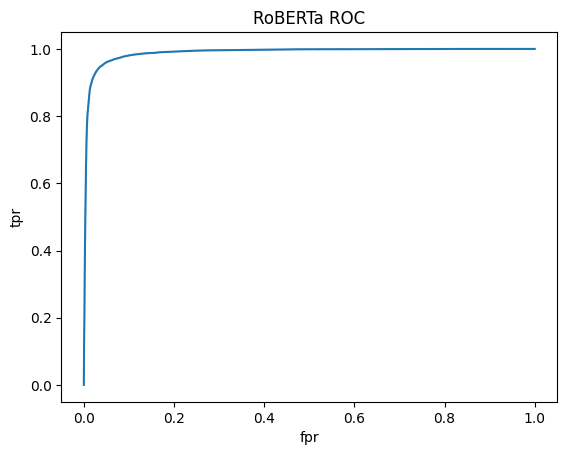

In [9]:
fpr, tpr, thresholds = roc_curve(labels, testpreds)
ax=sns.lineplot(x=fpr,y=tpr)
ax.set(title="RoBERTa ROC", xlabel="fpr", ylabel="tpr")

In [ ]:
len(fpr)
len(tpr)
len(labels)
len(testpreds)

In [ ]:
[pred for pred in testpreds if 0<pred<1]

In [7]:
testpreds

[[-3.619565725326538, -0.0271597933024168],
 [-4.236130714416504, -0.014569089747965336],
 [-0.0044555203057825565, -5.415849685668945],
 [-1.2267041206359863, -0.34708890318870544],
 [-3.909982681274414, -0.020244402810931206],
 [-0.003436019876971841, -5.67514705657959],
 [-0.012278917245566845, -4.406001567840576],
 [-0.010338325053453445, -4.577057361602783],
 [-3.240785598754883, -0.0399194099009037],
 [-0.462839275598526, -0.9928852319717407],
 [-4.254096984863281, -0.014307769015431404],
 [-0.009446446783840656, -4.666838645935059],
 [-0.0036149173974990845, -5.6244940757751465],
 [-4.443853855133057, -0.011820157989859581],
 [-0.0072221397422254086, -4.9342122077941895],
 [-0.003379825735464692, -5.691610336303711],
 [-4.4723334312438965, -0.011486350558698177],
 [-4.37846565246582, -0.012623995542526245],
 [-0.47059616446495056, -0.9798424243927002],
 [-4.259901523590088, -0.01422432903200388],
 [-0.0019693044014275074, -6.231048107147217],
 [-0.0018635302549228072, -6.2862329